## Load and preprocess data

In [1]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load CSV data
df = pd.read_csv("TrackedRawData_55_video1_Experiment-777.csv")
df = df.sort_values(by=["TID", "PID"]).reset_index(drop=True)

# Calculate movement features
df["dx"] = df.groupby("TID")["x [pixel]"].diff()
df["dy"] = df.groupby("TID")["y [pixel]"].diff()
df["distance_um"] = np.sqrt(df["dx"]**2 + df["dy"]**2) * 0.248
df["speed_ums"] = df["distance_um"] * 60
df["angle"] = np.arctan2(df["dy"], df["dx"])
df["dtheta"] = df.groupby("TID")["angle"].diff()
df["is_run"] = ((df["speed_ums"] > 13) & (np.abs(df["dtheta"]) < np.deg2rad(45))).astype(int)
df = df.dropna(subset=["x [pixel]", "y [pixel]", "speed_ums", "angle", "is_run"]).reset_index(drop=True)


## Create sequences and conditions

In [2]:

features = ["x [pixel]", "y [pixel]", "speed_ums", "angle", "is_run"]
T = 30

sequences = []
conditions = []
for tid, group in df.groupby("TID"):
    data = group[features].values
    if len(data) >= T:
        for i in range(len(data) - T + 1):
            seq = data[i:i+T]
            sequences.append(seq)
            cond = seq[0, :]  # initial condition
            conditions.append(cond)

sequences = torch.tensor(np.stack(sequences), dtype=torch.float32)  # [N, T, F]
conditions = torch.tensor(np.stack(conditions), dtype=torch.float32)  # [N, F]
print(sequences.shape, conditions.shape)


torch.Size([12867, 30, 5]) torch.Size([12867, 5])


## Define Generator and Discriminator

In [3]:

class Generator(nn.Module):
    def __init__(self, noise_dim=16, cond_dim=5, hidden_dim=64, seq_len=30, out_dim=5):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + cond_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, seq_len * out_dim)
        )
        self.seq_len = seq_len
        self.out_dim = out_dim

    def forward(self, z, cond):
        x = torch.cat([z, cond], dim=1)
        out = self.model(x)
        return out.view(-1, self.seq_len, self.out_dim)

class Discriminator(nn.Module):
    def __init__(self, cond_dim=5, hidden_dim=64, seq_len=30, in_dim=5):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(seq_len * in_dim + cond_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        self.seq_len = seq_len
        self.in_dim = in_dim

    def forward(self, x, cond):
        x = x.view(x.size(0), -1)
        x = torch.cat([x, cond], dim=1)
        return self.model(x)


## Train cGAN

In [70]:
batch_size = 64
noise_dim = 16
num_epochs = 20
lr = 0.0002

dataset = TensorDataset(sequences, conditions)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

G = Generator(noise_dim=noise_dim)
D = Discriminator()
g_opt = optim.Adam(G.parameters(), lr=lr)
d_opt = optim.Adam(D.parameters(), lr=lr)
bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

for epoch in range(num_epochs):
    for x_real, c in loader:
        z = torch.randn(x_real.size(0), noise_dim)
        x_fake = G(z, c)

        # Discriminator loss
        d_real = D(x_real, c)
        d_fake = D(x_fake.detach(), c)
        d_loss = bce_loss(d_real, torch.ones_like(d_real)) + bce_loss(d_fake, torch.zeros_like(d_fake))
        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()

        # Generator loss with chemotaxis
        chemo_weight = 0.5  # 🧭 adjustable chemotaxis strength
        d_fake = D(x_fake, c)
        x_positions = x_fake[:, :, 0]  # x position
        chemo_bias = torch.mean(x_positions) / 660.0  # normalized chemotaxis reward (0~1)
        g_loss = (
            bce_loss(d_fake, torch.ones_like(d_fake)) +
            10 * l1_loss(x_fake, x_real) -
            chemo_weight * chemo_bias
        )
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

    # The print statement should be indented at this level
    print(f"Epoch {epoch+1}/{num_epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} | ChemoBias: {chemo_bias.item():.4f}")

Epoch 1/20 | D Loss: 0.4369 | G Loss: 531.5120 | ChemoBias: 0.3811
Epoch 2/20 | D Loss: 0.7261 | G Loss: 237.5823 | ChemoBias: 0.4183
Epoch 3/20 | D Loss: 0.2814 | G Loss: 175.7114 | ChemoBias: 0.6444
Epoch 4/20 | D Loss: 1.5040 | G Loss: 67.2426 | ChemoBias: 0.2145
Epoch 5/20 | D Loss: 0.7977 | G Loss: 83.2961 | ChemoBias: 0.2870
Epoch 6/20 | D Loss: 0.5456 | G Loss: 71.1834 | ChemoBias: 0.2763
Epoch 7/20 | D Loss: 1.3411 | G Loss: 65.2424 | ChemoBias: 0.5322
Epoch 8/20 | D Loss: 0.9772 | G Loss: 57.1441 | ChemoBias: 0.6950
Epoch 9/20 | D Loss: 1.0991 | G Loss: 42.4161 | ChemoBias: 0.6645
Epoch 10/20 | D Loss: 1.1913 | G Loss: 58.7274 | ChemoBias: 0.5454
Epoch 11/20 | D Loss: 1.6208 | G Loss: 45.3544 | ChemoBias: 0.6475
Epoch 12/20 | D Loss: 1.0891 | G Loss: 51.4923 | ChemoBias: 0.4914
Epoch 13/20 | D Loss: 1.7318 | G Loss: 45.9733 | ChemoBias: 0.6039
Epoch 14/20 | D Loss: 1.1771 | G Loss: 46.4080 | ChemoBias: 0.7267
Epoch 15/20 | D Loss: 1.1763 | G Loss: 74.6840 | ChemoBias: 0.4363
E

In [71]:
# Save trained generator
torch.save(G.state_dict(), "generator_with_chemotaxis.pth")


## Generate and visualize trajectories

In [72]:

# Load trained generator for sampling
G = Generator(noise_dim=noise_dim)
G.load_state_dict(torch.load("generator_with_chemotaxis.pth", map_location="cpu"))
G.eval()


Generator(
  (model): Sequential(
    (0): Linear(in_features=21, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=150, bias=True)
  )
)

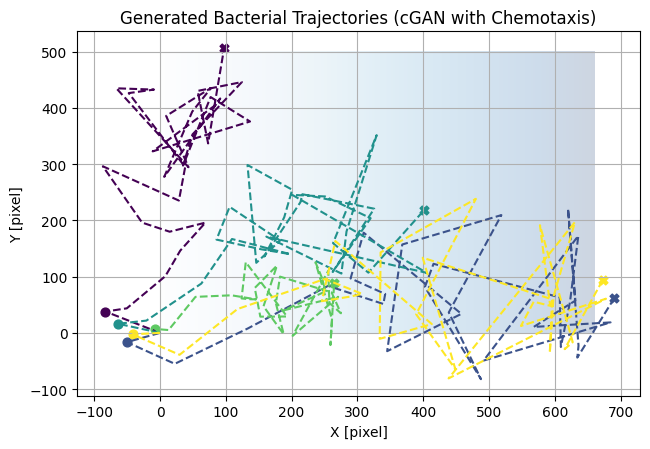

In [81]:
n = 5
samples = []
colors = plt.cm.viridis(np.linspace(0, 1, n))

plt.figure(figsize=(6.6, 4.6))

# Gradient
gradient = np.tile(np.linspace(0, 1, 660), (500, 1))
plt.imshow(gradient, origin='lower', cmap='Blues', alpha=0.2, aspect='auto')

for i in range(n):
    idx = np.random.randint(0, len(conditions))
    cond = conditions[idx:idx+1]
    z = torch.randn(1, noise_dim)
    traj = G(z, cond).detach().numpy().squeeze()
    df_traj = pd.DataFrame(traj, columns=["x", "y", "speed", "angle", "is_run"])

    dx = df_traj["x"].diff().fillna(0).values
    dy = df_traj["y"].diff().fillna(0).values
    x = np.cumsum(dx * 100)
    y = np.cumsum(dy * -100)

    plt.plot(x, y, "--", color=colors[i], label=f"Bacteria {i+1}")
    plt.scatter(x[1], y[1], color=colors[i], s=40, marker='o', label=f"Start {i+1}")
    plt.scatter(x[-1], y[-1], color=colors[i], s=40, marker='X', label=f"End {i+1}")

plt.xlabel("X [pixel]")
plt.ylabel("Y [pixel]")
plt.title("Generated Bacterial Trajectories (cGAN with Chemotaxis)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
